In [99]:
from warnings import simplefilter
# ignore all future warnings / convergence warnings, !!! In a real workflow do not do this !!!
simplefilter(action='ignore', category=FutureWarning)
simplefilter(action='ignore', category=DeprecationWarning)
import descarteslabs as dl
import numpy as np
import pickle
from descarteslabs.client.services import Places
import pandas as pd
import matplotlib as mpl
import matplotlib.patches as patches
from matplotlib import pyplot as plt
from tqdm.notebook import tqdm
import descarteslabs.workflows as wf
import shapely.geometry
import shapely.ops
import shapely.prepared
import rasterio.features
from tqdm.notebook import tqdm
%matplotlib inline
# 65535

In [100]:
def get_monthly_arrays(data, info):
    years = sorted(list(set([x['group'][0] for x in info])))
    months = sorted(list(set([x['group'][1] for x in info])))
    dates_ = list(zip(np.arange(data.shape[0], dtype=int), [x['group'] for x in info]))
    date_ranges = {(x,y): [] for x in years for y in range(1,13)}
    for d in dates_:
        date_ranges[d[1][:2]].append(d[0])
    avg_array = np.zeros((12*len(years), data.shape[1], data.shape[2], data.shape[3]))
    for k, dr in enumerate(sorted([(x,y) for x in years for y in months])):
        if date_ranges[dr]:
            avg_array[k] = data[date_ranges[dr][0]:date_ranges[dr][-1]+1].mean(axis=0)
    return avg_array

In [97]:
sac = shapely.geometry.shape(
    dl.places.shape("north-america_united-states_california_sacramento-valley").geometry
)
sj = shapely.geometry.shape(
    dl.places.shape(
        "north-america_united-states_california_san-joaquin-valley"
    ).geometry
)
central_valley_aoi = sac.union(sj)

tiles = dl.scenes.DLTile.from_shape(
    central_valley_aoi, resolution=15, tilesize=512, pad=0
)
print(len(tiles))
start_datetime = "2019-01-01"
end_datetime = "2020-01-01"

1917


In [96]:
def cloud_masked_daily_product(product_id: str, start_datetime: str, end_datetime: str) -> wf.ImageCollection:
    "Get a product by ID, masked by the DL cloud mask and mosaicked by day"
    if 'airbus' in product_id.lower():
        cloud = 'derived:visual_cloud_mask'
    else:
        cloud = "valid-cloudfree"
    ic = wf.ImageCollection.from_id(product_id, start_datetime, end_datetime)
    cloudmask = (
        wf.ImageCollection.from_id(
            product_id, start_datetime, end_datetime
        ).pick_bands(cloud)
        == 0
    )

    # Make an ImageCollectionGroupby object, for quicker lookups from `ic` by date (you can use it like a dict)
    ic_date_groupby = ic.groupby(dates=("year", "month", "day"))
    # For each cloudmask date, pick the corresponding image from `ic` by date, mosiac both, and mask them.
    # (Not all scenes have cloudmasks processed, so this ensures we only return scenes that do.)
    return cloudmask.groupby(dates=("year", "month", "day")).map(
        lambda ymd, mask_imgs: ic_date_groupby[ymd].mosaic().mask(mask_imgs.mosaic())
    )

def ndvi(ic: wf.ImageCollection) -> wf.ImageCollection:
    nir, red = ic.unpack_bands("nir red")
    ndvi = (nir - red) / (nir + red)
    return ndvi.rename_bands("ndvi")

def isin(ic: wf.ImageCollection, values: list) -> wf.ImageCollection:
    "Like np.isin, for Workflows"
    assert len(values) > 0
    result = False
    for value in values:
        result = result | (ic == value)
    return result

In [95]:
start_datetime = "2019-01-01"
end_datetime = "2020-01-01"
l8_daily = cloud_masked_daily_product(
    "landsat:LC08:01:T1:TOAR", start_datetime, end_datetime
).pick_bands("red green blue nir swir1")
l8_with_ndvi = l8_daily.concat_bands(ndvi(l8_daily))
ab_ic = wf.ImageCollection.from_id(
    "airbus:oneatlas:spot:v2", start_datetime=start_datetime, end_datetime=end_datetime
).pick_bands("red green blue")
ab_date_groupby = ab_ic.groupby(dates=("year", "month", "day"))
ab_daily = ab_ic.groupby(dates=("year", "month", "day")).map(
        lambda ymd, mask_imgs: ab_date_groupby[ymd].mosaic())
cdl = wf.ImageCollection.from_id(
    "usda:cdl:v1", start_datetime="2019-01-01", end_datetime="2020-01-01"
).pick_bands("class")

grains_oils_grass_beans = [1,2,3,4,5,6,10,11,12,13,21,22,23,24,25,26,27,28,29,
                        30,31,32,33,34,35,36,37,38,39,41,42,43,44,45,46,51,
                        52,53,225,226,228,230,232,234,235,236,237,238,239,240,241,254]

deli_crops = [14, 48, 49, 50, 54, 55, 57, 206, 207, 208, 209, 213, 214, 216,
            219, 221, 222, 224, 227, 229, 231, 242, 243, 244, 245, 246, 247,
            248, 249, 250]

tree_crops = [66, 67, 68, 69, 72, 74, 75, 76, 77, 204, 210, 211, 212, 215, 217,
            218,220, 223]

crops_list = deli_crops + tree_crops
crops_enc = {id_: k + 1 for k, id_ in enumerate(sorted(crops_list))}
crops_enc[0] = 0
crops_dec = {crops_enc[id_]: id_ for id_ in crops_enc}

is_crops = isin(cdl, crops_list)
is_crops_19 = is_crops[-1]

four_year_combo = is_crops.sum(axis="images") + is_crops_19  # double-weight 2019
four_year_binary = four_year_combo >= 2
cdl_mask = ~four_year_binary

l8_masked = l8_with_ndvi.mask(cdl_mask)

In [94]:
from typing import Iterator, Sequence
import time
import descarteslabs.workflows as wf

def as_completed(jobs: Sequence[wf.Job], interval_sec: int = 5) -> Iterator[wf.Job]:
    jobs = list(jobs)
    while len(jobs) > 0:
        loop_start = time.perf_counter()
        i = 0
        while i < len(jobs):
            job = jobs[i]
            if not job.done:  # in case it's already loaded
                try:
                    job.refresh()
                except Exception:
                    continue  # be resilient to transient errors for now
            if job.done:
                yield job
                del jobs[i]  # "advances" i
            else:
                i += 1
        loop_duration = time.perf_counter() - loop_start
        if len(jobs) > 0 and loop_duration < interval_sec:
            time.sleep(interval_sec - loop_duration)
            
def handle_result(tile, l8_data, l8_info, cdl_data):
    print(tile.key, l8_data.shape, get_monthly_arrays(l8_data, l8_info).shape)
    # TODO: do whatever you'd do with the result!

In [93]:
def process_cdl(cdl_r, valid_crops):
    flat = np.array(cdl_r).reshape(512*512)
    flat = pd.Series(flat).apply(lambda v: v * (int(v) in valid_crops))
    flat = flat.apply(lambda v: crops_enc[int(v)])
    return flat.values.reshape((512,512))

def get_rf_data(img, crop, valid_crops):
    crop = process_cdl(crop, valid_crops)
    nz = np.where(crop > 0)
    res_y = crop[nz]
    res_x = img[:,:,nz[0],nz[1]].reshape((60,nz[0].shape[0])).transpose((1,0))
    return res_x, res_y

def get_single_crop_data(crops_list_):
    cdl = wf.ImageCollection.from_id(
        "usda:cdl:v1", start_datetime="2019-01-01", end_datetime="2020-01-01"
    ).pick_bands("class")
    is_crops = isin(cdl, crops_list_)
    is_crops_19 = is_crops[-1]
    four_year_combo = is_crops.sum(axis="images") + is_crops_19  # double-weight 2019
    four_year_binary = four_year_combo >= 2
    cdl_mask = ~four_year_binary
    l8_masked = l8_with_ndvi.mask(cdl_mask)
    central_valley_ctx = dl.scenes.AOI(central_valley_aoi, shape=(2048, 2048), crs="EPSG:4326")
    all_cdl = four_year_binary.compute(central_valley_ctx)
    shapes = list(
    geom for geom, value in
    rasterio.features.shapes(
        all_cdl.ndarray.astype("uint8"), 
        transform=rasterio.transform.Affine.from_gdal(*all_cdl.geocontext["gdal_geotrans"])
            )
            if value == 1
                )
    print(f"Len Shapes: {len(shapes)}")
    all_valid = shapely.ops.unary_union([shapely.geometry.shape(s) for 
                                         s in shapes]).simplify(0.3)
    all_valid_prepped = shapely.prepared.prep(all_valid)
    valid_tiles = [t for t in tqdm(tiles) if all_valid_prepped.intersects(t.geometry)]
    print(len(valid_tiles), len(valid_tiles) / len(tiles))
    if len(valid_tiles) < 1:
        return None, None
    failed = []
    tile_imgs = []
    tile_infs = []
    cdl_infs = []
    valid_tiles_ = np.random.choice(valid_tiles, min(10, len(valid_tiles)), replace=False)
    for k in tqdm(range(len(valid_tiles_))):
        tiles_to_run = [valid_tiles_[k]]
        jobs = [wf.compute([l8_daily.ndarray, l8_daily.properties, cdl.ndarray], 
                           tile, block=False) for tile in tiles_to_run]
        job_to_tile = {j: t for j, t in zip(jobs, tiles_to_run)}
        for job in as_completed(jobs):
            if job.error is not None:
                failed.append(job)
                print(job.error)
            else:
                l8_data, l8_info, cdl_data = job.result(progress_bar=False)
                tile = job_to_tile[job]
                tile_imgs.append(l8_data)
                tile_infs.append(l8_info)
                cdl_infs.append(cdl_data)
    X, y = get_rf_data(get_monthly_arrays(tile_imgs[0], tile_infs[0]), 
                       cdl_infs[0],
                      crops_list_)
    for k in range(1, len(valid_tiles_)):
        X_c, y_c = get_rf_data(get_monthly_arrays(tile_imgs[k], tile_infs[k]), 
                               cdl_infs[k], 
                               crops_list_)
        X = np.concatenate((X,X_c))
        y = np.concatenate((y, y_c))
    print(X.shape, y.shape)
    return X, y

```
X_t, y_t = get_single_crop_data([222])
#r_ix = np.random.choice(X_t.shape[0], 10000, False)
#X_t, y_t = X_t[r_ix], y_t[r_ix]
bad_id = []
for crop_id in [id_ for id_ in crops_list if id_ != 222]:
    try:
        X_c, y_c = get_single_crop_data([crop_id])
    except Exception as e:
        bad_id.append(crop_id)
        X_c = None
        print(f"Error, adding {crop_id} to bad_id list")
    if X_c is None:
        pass
    else:
        if X_c.shape[0] > 10000:
            r_ix = np.random.choice(X_c.shape[0], 10000, False)
            X_c, y_c = X_c[r_ix], y_c[r_ix]
        X_t, y_t = np.concatenate((X_t, X_c)), np.concatenate((y_t, y_c))
pd.DataFrame(pd.Series(y_c).value_counts())
```

```
# replace ... with full path on your machine
X_fp = r'...\u_net_3d\saved_models\saved_data\x_rf.npy'
y_fp = r'...\u_net_3d\saved_models\saved_data\y_rf.npy'
X_t = np.load(X_fp)
y_t = np.load(y_fp)
```

In [104]:
def process_crop_split(x):
    split = x.split()
    crop = ''
    for s in split:
        if not s.isnumeric():
            crop += f"{s} "
        else:
            return crop[:-1], int(s)
# replace ... with full path on your machine
fp = r'...\u_net_3d\saved_models\saved_data\label_map.txt'
text = ""
with open(fp, 'r') as file:
    for line in file.read():
        text += line
text = text.split('\n')[3:]
crop_label_enc = {process_crop_split(x)[1]: process_crop_split(x)[0] for x in text}
crop_label_dec = {crop_label_enc[k]: k for k in crop_label_enc}
y_t = np.array([crop_label_enc[crops_dec[y_]] for y_ in y_t])

FileNotFoundError: [Errno 2] No such file or directory: 'saved_models\\saved_data\\label_map.txt'

In [79]:
pd.DataFrame(pd.Series(y_t).value_counts(), columns=['Count'])

,Count
Squash,12662
Almonds,10000
Broccoli,10000
Citrus,10000
Onions,10000
Olives,10000
Grapes,10000
Pears,10000
Carrots,10000
Cherries,10000


In [80]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

In [91]:
import seaborn as sns
def get_conf_matrix(y_true, y_pred, labels, save=False):
    df = pd.DataFrame(confusion_matrix(y_true, y_pred, labels))
    df.columns = [f'Predicted {lab}' for lab in labels]
    df.index = [f'True {lab}' for lab in labels]
    cmap = sns.light_palette((237, 85, 74), input="husl",as_cmap=True)
    plt.figure(figsize=(25,25))
    sns.heatmap(df,annot=True, fmt='d', cbar=0, cmap=cmap, annot_kws={"size": 20})
    if save:
        plt.savefig(save)
    plt.show()

In [82]:
X_train, X_test, y_train, y_test = train_test_split(X_t, y_t, test_size=0.2, random_state=2020)

In [83]:
clf = RandomForestClassifier() # Will try default hyperparameters to start
clf.fit(X_train, y_train)

RandomForestClassifier()

0.9553705517466536


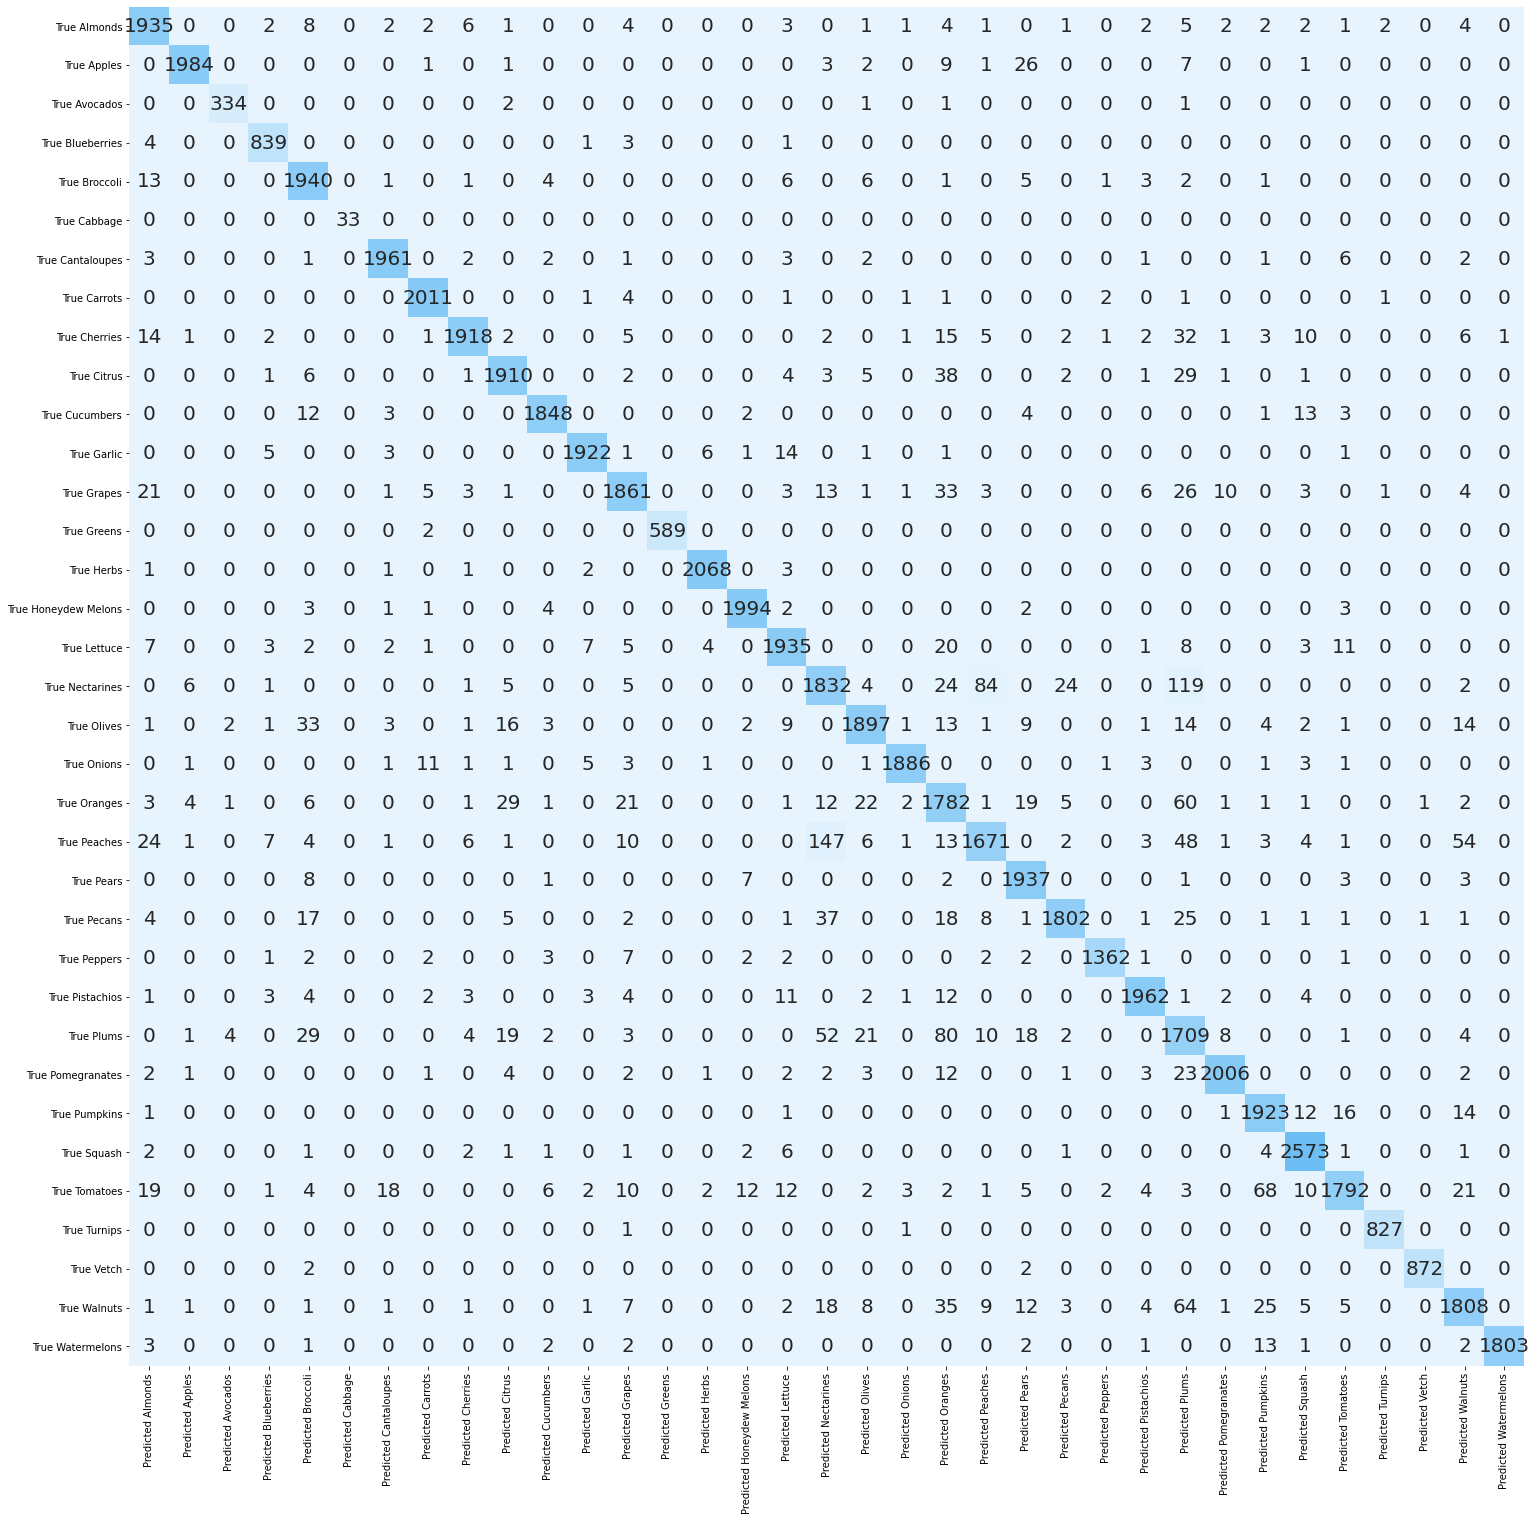

In [92]:
#preds = clf.predict(X_test)
print(accuracy_score(y_test, preds))
save_fp = r'C:\Users\DIOTJA\PycharmProjects\u_net_3d\saved_models\saved_data\cfm.png'
get_conf_matrix(y_test, preds, clf.classes_, save_fp)